In [1]:
# https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/cifar10/03_CGAN_CIFAR10.ipynb
from google.colab import drive

drive.mount("/content/gdrive/", force_remount=True)
%cd gdrive/MyDrive/

Mounted at /content/gdrive/
/content/gdrive/MyDrive


In [2]:
# import the required packages
import numpy as np
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import (
    Activation,
    BatchNormalization,
    Concatenate,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GaussianNoise,
    Input,
    LeakyReLU,
    multiply,
    Reshape,
)
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

In [3]:
# load the dataset and class labels
X = np.load("anime_face_images/anime_face_images.npy")
y = np.load("anime_face_images/kmeans_labels.npy").reshape(-1, 1)
num_classes = len(np.unique(y))
print(f"Number of classes = {num_classes}")
print(f"X shape = {X.shape}")
print(f"Shape of the images = {X[0].shape}")

Number of classes = 6
X shape = (21551, 64, 64, 3)
Shape of the images = (64, 64, 3)


In [4]:
def make_generator_model():
    # latent space dimension
    z = Input(shape=(100,))

    # classes
    labels = Input(shape=(6,))

    # FC: 4x4x512
    generator = Dense(4 * 4 * 512, activation="relu")(Concatenate()([z, labels]))
    generator = BatchNormalization(momentum=0.9)(generator)
    generator = LeakyReLU(alpha=0.1)(generator)
    generator = Reshape((4, 4, 512))(generator)

    # Conv 1: 8x8x256
    generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding="same")(generator)
    generator = BatchNormalization(momentum=0.9)(generator)
    generator = LeakyReLU(alpha=0.1)(generator)

    # Conv 2: 16x16x128
    generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding="same")(generator)
    generator = BatchNormalization(momentum=0.9)(generator)
    generator = LeakyReLU(alpha=0.1)(generator)

    # Conv 3: 32x32x64
    generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding="same")(generator)
    generator = BatchNormalization(momentum=0.9)(generator)
    generator = LeakyReLU(alpha=0.1)(generator)

    # Conv 4: 64x64x3
    generator = Conv2DTranspose(
        3, kernel_size=5, strides=2, padding="same", activation="tanh"
    )(generator)

    # generator = Model(inputs=[z, labels], outputs=out_g)
    generator = Model(inputs=[z, labels], outputs=generator, name="generator")
    generator.summary()
    return generator

generator = make_generator_model()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 106)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 8192)         876544      ['concatenate[0][0]']    

In [5]:
def make_discriminator_model():
    # classes
    labels = Input(shape=(6,))

    # input image
    img_input = Input(shape=(X[0].shape))

    # Conv 1: 16x16x64
    discriminator = Conv2D(
        64, kernel_size=5, strides=2, padding="same"
    )(img_input)
    discriminator = BatchNormalization(momentum=0.9)(discriminator)
    discriminator = LeakyReLU(alpha=0.1)(discriminator)

    # Conv 2:
    discriminator = Conv2D(
        128, kernel_size=5, strides=2, padding="same"
    )(discriminator)
    discriminator = BatchNormalization(momentum=0.9)(discriminator)
    discriminator = LeakyReLU(alpha=0.1)(discriminator)

    # Conv 3: 
    discriminator = Conv2D(
        256, kernel_size=5, strides=2, padding="same"
    )(discriminator)
    discriminator = BatchNormalization(momentum=0.9)(discriminator)
    discriminator = LeakyReLU(alpha=0.1)(discriminator)

    # Conv 4: 
    discriminator = Conv2D(
        512, kernel_size=5, strides=2, padding="same"
    )(discriminator)
    discriminator = BatchNormalization(momentum=0.9)(discriminator)
    discriminator = LeakyReLU(alpha=0.1)(discriminator)

    # FC
    discriminator = Flatten()(discriminator)

    # Concatenate 
    merged_layer = Concatenate()([discriminator, labels])
    discriminator = Dense(512, activation="relu")(merged_layer)
        
    # Output
    discriminator = Dense(1, activation="sigmoid")(discriminator)

    discriminator = Model(
        inputs=[img_input, labels], outputs=discriminator, name="discriminator"
    )

    discriminator.summary()
    return discriminator

discriminator = make_discriminator_model()

# compile the discriminator
discriminator.compile(
    Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)

# freeze the discriminator's weights
discriminator.trainable = False

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   4864        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 32, 32, 64)   0           ['batch_normalization

In [6]:
label = Input(shape=(6,), name="label")
z = Input(shape=(100,), name="z")

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name="adversarial")

d_g.compile(
    Adam(lr=0.0004, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=["binary_accuracy"]
)
d_g.summary()

Model: "adversarial"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 z (InputLayer)                 [(None, 100)]        0           []                               
                                                                                                  
 label (InputLayer)             [(None, 6)]          0           []                               
                                                                                                  
 generator (Functional)         (None, 64, 64, 3)    5217155     ['z[0][0]',                      
                                                                  'label[0][0]']                  
                                                                                                  
 discriminator (Functional)     (None, 1)            8508801     ['generator[0][0]',    

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


epoch = 1/300, d_loss=0.163, g_loss=0.000                                                                                                     
1/1 [==============================] - 0s 112ms/step


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


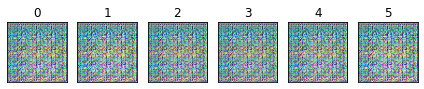

epoch = 2/300, d_loss=0.163, g_loss=0.000                                                                                                     
epoch = 3/300, d_loss=0.163, g_loss=0.000                                                                                                     
epoch = 4/300, d_loss=0.163, g_loss=0.000                                                                                                     
epoch = 5/300, d_loss=0.163, g_loss=0.000                                                                                                     
epoch = 6/300, d_loss=0.163, g_loss=0.000                                                                                                     
epoch = 7/300, d_loss=0.163, g_loss=0.000                                                                                                     
epoch = 8/300, d_loss=0.163, g_loss=0.000                                                                                                     

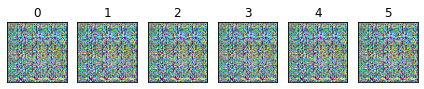

epoch = 12/300, d_loss=0.163, g_loss=0.000                                                                                                     
epoch = 13/300, d_loss=0.175, g_loss=0.897                                                                                                     
epoch = 14/300, d_loss=0.163, g_loss=0.113                                                                                                     
epoch = 15/300, d_loss=0.163, g_loss=0.088                                                                                                     
epoch = 16/300, d_loss=0.163, g_loss=0.081                                                                                                     
epoch = 17/300, d_loss=0.163, g_loss=0.079                                                                                                     
epoch = 18/300, d_loss=0.163, g_loss=0.075                                                                                              

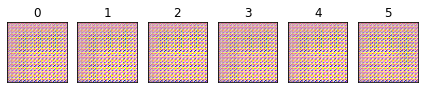

epoch = 22/300, d_loss=0.163, g_loss=0.041                                                                                                     
epoch = 23/300, d_loss=0.163, g_loss=0.027                                                                                                     
epoch = 24/300, d_loss=0.163, g_loss=0.015                                                                                                     
epoch = 25/300, d_loss=0.163, g_loss=0.012                                                                                                     
epoch = 26/300, d_loss=0.163, g_loss=0.008                                                                                                     
epoch = 27/300, d_loss=0.163, g_loss=0.007                                                                                                     
epoch = 28/300, d_loss=0.163, g_loss=0.006                                                                                              

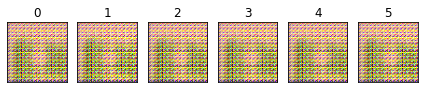

epoch = 32/300, d_loss=0.163, g_loss=0.012                                                                                                     
epoch = 33/300, d_loss=0.163, g_loss=0.014                                                                                                     
epoch = 34/300, d_loss=0.163, g_loss=0.021                                                                                                     
epoch = 35/300, d_loss=0.163, g_loss=0.020                                                                                                     
epoch = 36/300, d_loss=0.163, g_loss=0.027                                                                                                     
epoch = 37/300, d_loss=0.163, g_loss=0.021                                                                                                     
epoch = 38/300, d_loss=0.163, g_loss=0.018                                                                                              

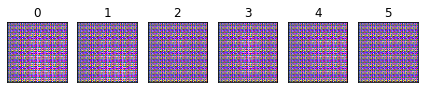

epoch = 42/300, d_loss=0.163, g_loss=0.091                                                                                                     
epoch = 43/300, d_loss=0.163, g_loss=0.054                                                                                                     
epoch = 44/300, d_loss=0.163, g_loss=0.048                                                                                                     
epoch = 45/300, d_loss=0.163, g_loss=0.044                                                                                                     
epoch = 46/300, d_loss=0.163, g_loss=0.043                                                                                                     
epoch = 47/300, d_loss=0.163, g_loss=0.043                                                                                                     
epoch = 48/300, d_loss=0.163, g_loss=0.044                                                                                              

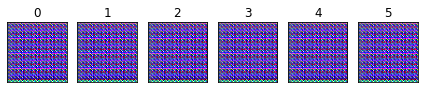

epoch = 52/300, d_loss=0.163, g_loss=0.047                                                                                                     
epoch = 53/300, d_loss=0.163, g_loss=0.047                                                                                                     
epoch = 54/300, d_loss=0.163, g_loss=0.049                                                                                                     
epoch = 55/300, d_loss=0.163, g_loss=0.050                                                                                                     


In [ ]:
epochs = 300
batch_size = 64
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

tf.config.run_functions_eagerly(True)

for e in range(epochs + 1):
    for i in range(len(X) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(
            y[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=6
        )
        
        d_loss_real = discriminator.train_on_batch(
            x=[X_batch, real_labels], y=real * (1 - smooth)
        )
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(
            np.random.randint(0, 6, batch_size).reshape(-1, 1), num_classes=6
        )
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(
            x=[X_fake, random_labels], y=fake
        )
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(
            np.random.randint(0, 6, batch_size).reshape(-1, 1), num_classes=6
        )
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            f"epoch = {e + 1}/{epochs}, batch = {i}/{len(X) // batch_size}, "
            f"d_loss={d_loss_batch:.3f}, g_loss={d_g_loss_batch[0]:.3f}",
            100 * " ", end="\r"
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])

    print(
        f"epoch = {e + 1}/{epochs}, d_loss={d_loss_batch:.3f}, "
        f"g_loss={d_g_loss_batch[0]:.3f}",
        100 * " "
    )

    if e % 10 == 0:
        samples = 6
        z = np.random.normal(loc=0, scale=1, size=(6, latent_dim))
        labels = to_categorical(np.arange(0, 6).reshape(-1, 1), num_classes=6)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype("uint8")

        for k in range(samples):
            plt.subplot(2, 6, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(k)

        plt.tight_layout()
        plt.show()

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Discriminator", "Adversarial"], loc="center right")
plt.show()